<a href="https://colab.research.google.com/github/md-abu-shayid/Bengali_Hand_written_digit_recognization/blob/main/Bengali_Hand_written_digit_recognization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd

#Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

#Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abushayid","key":"68d08c702d08a863cdc3f510a52d6e1d"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d BengaliAI/numta

100% 1.90G/1.91G [01:14<00:00, 35.5MB/s]
100% 1.91G/1.91G [01:14<00:00, 27.5MB/s]


In [ ]:
!unzip numta.zip

In [ ]:
!ls

kaggle.json	       testing-augc  training-a      training-d
numta.zip	       testing-b     training-a.csv  training-d.csv
sample_data	       testing-c     training-b      training-e
testing-a	       testing-d     training-b.csv  training-e.csv
testing-all-corrected  testing-e     training-c
testing-auga	       testing-f     training-c.csv


In [ ]:
PATH = '/content/'
os.listdir(PATH)

['.config',
 'training-e',
 'training-c',
 'testing-f',
 'testing-all-corrected',
 'testing-augc',
 'numta.zip',
 'testing-a',
 'training-d.csv',
 'testing-d',
 'testing-b',
 'training-d',
 'testing-auga',
 'kaggle.json',
 'training-b',
 'testing-c',
 'training-a.csv',
 'training-e.csv',
 'training-b.csv',
 'training-a',
 'testing-e',
 'training-c.csv',
 'sample_data']

In [ ]:
# Hyperparameters

batch_size = 220
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Step 1 : Process the data**

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(PATH + csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
a_csv = showRawTrainingSamples('training-a.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
data_csv = dropColumns(a_csv)

     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0


In [ ]:
TRAIN_PATH = '/content/training-a'

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]

        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_dataset  = Dataset(data_csv, TRAIN_PATH, train_transform)
test_dataset = Dataset(data_csv, TRAIN_PATH, test_transform)
print("Trainig Samples: ",len(train_dataset))

Trainig Samples:  19702


In [ ]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_dataset)

# mix data
# index of num of train
indices = list(range(num_train))

# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))

# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

print("Train Samples: ",len(train_idx))
print("Test Samples: ",len(test_idx))

Train Samples:  17732
Test Samples:  1970


In [ ]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

print('Total Epochs: '+ str(num_epochs))

# prepare loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,sampler=test_sampler)

print("Train dataloader: {}".format(len(train_loader)))
print("Test dataloader: {}".format(len(test_loader)))

Total Epochs: 55
Train dataloader: 81
Test dataloader: 9


In [ ]:
# Inspecting a single image (28 pixel x 28 pixel) -->  28x28 matrix of numbers
train_dataset[0]

(tensor([[[ 0.6392,  0.6392,  0.6392,  0.6392,  0.6471,  0.6392,  0.6392,
            0.6471,  0.6392,  0.6392,  0.6471,  0.6392,  0.6314,  0.6314,
            0.6392,  0.6314,  0.6235,  0.6314,  0.6392,  0.6314,  0.6314,
            0.6314,  0.6392,  0.6392,  0.6471,  0.6471,  0.6471,  0.6471],
          [ 0.6471,  0.6471,  0.6471,  0.6471,  0.6471,  0.6471,  0.6471,
            0.6471,  0.6471,  0.6471,  0.6392,  0.6392,  0.6392,  0.6392,
            0.6314,  0.6314,  0.6314,  0.6314,  0.6392,  0.6392,  0.6471,
            0.6471,  0.6392,  0.6392,  0.6392,  0.6392,  0.6392,  0.6471],
          [ 0.6471,  0.6471,  0.6471,  0.6471,  0.6471,  0.6549,  0.6549,
            0.6471,  0.6549,  0.6471,  0.6392,  0.6471,  0.6471,  0.6392,
            0.6392,  0.6392,  0.6314,  0.6314,  0.6392,  0.6392,  0.6392,
            0.6392,  0.6392,  0.6392,  0.6392,  0.6314,  0.6471,  0.6471],
          [ 0.6471,  0.6549,  0.6549,  0.6549,  0.6549,  0.6549,  0.6549,
            0.6549,  0.6549,  0.647

In [ ]:
# One Image Size
print(train_dataset[0][0].numpy().shape)

# First Image Label
print(train_dataset[0][1])

(1, 28, 28)
5


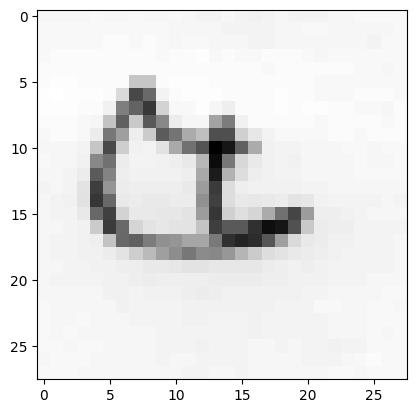

In [ ]:
## Displaying a Bangla Handwritten Digit Image
show_img = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

# **Step 2 : Design the model**

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)    #Input Layer
        self.fc2 = nn.Linear(512, 256)          #Hidden Layer
        self.fc3 = nn.Linear(256, 128)          #Hidden Layer
        self.fc4 = nn.Linear(128, output_dim)   #Output Layer

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        probas = F.log_softmax(self.fc4(x), dim=1)
        logits = self.fc4(x)

        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,num_classes=output_dim)

# To enable GPU
model.to(device)

LogisticRegressionModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# **Step 3 : Train the model**

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images)

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:

                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total


            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 100. Loss: 2.273369073867798. Accuracy: 16.6497461928934
Iteration: 200. Loss: 2.0358059406280518. Accuracy: 31.116751269035532
Iteration: 300. Loss: 2.069166660308838. Accuracy: 38.47715736040609
Iteration: 400. Loss: 1.764577031135559. Accuracy: 42.43654822335025
Iteration: 500. Loss: 1.5060007572174072. Accuracy: 48.68020304568528
Iteration: 600. Loss: 1.413208246231079. Accuracy: 44.41624365482234
Iteration: 700. Loss: 1.3115434646606445. Accuracy: 54.213197969543145
Iteration: 800. Loss: 1.2126060724258423. Accuracy: 59.49238578680203
Iteration: 900. Loss: 1.2284265756607056. Accuracy: 58.17258883248731
Iteration: 1000. Loss: 1.2177788019180298. Accuracy: 61.421319796954315
Iteration: 1100. Loss: 1.159250020980835. Accuracy: 56.34517766497462
Iteration: 1200. Loss: 0.9985776543617249. Accuracy: 62.03045685279188
Iteration: 1300. Loss: 0.9832614064216614. Accuracy: 62.63959390862944
Iteration: 1400. Loss: 1.0829540491104126. Accuracy: 64.8730964467005
Iteration: 1500. Lo

In [ ]:
# Save model with accuracy
n = accuracy-int(accuracy)
if n>.5:
    last_accuracy = int(accuracy) +1
else:
    last_accuracy = int(accuracy)

[2.273369073867798, 2.0358059406280518, 2.069166660308838, 1.764577031135559, 1.5060007572174072, 1.413208246231079, 1.3115434646606445, 1.2126060724258423, 1.2284265756607056, 1.2177788019180298, 1.159250020980835, 0.9985776543617249, 0.9832614064216614, 1.0829540491104126, 0.9919947385787964, 0.9383677244186401, 0.901128888130188, 1.0782335996627808, 0.9007980227470398, 0.9716204404830933, 0.987902820110321, 0.78765869140625, 0.8604840636253357, 0.7489559054374695, 0.6238889098167419, 0.6381779313087463, 0.7782732248306274, 0.6784864068031311, 0.74452805519104, 0.6800410151481628, 0.702497124671936, 0.7887580990791321, 0.6721451282501221, 0.5812104940414429, 0.63801109790802, 0.6295644044876099, 0.7672585844993591, 0.5527100563049316, 0.6537194848060608, 0.5098400115966797, 0.586678147315979, 0.6705666780471802, 0.7679883241653442, 0.5799775719642639]


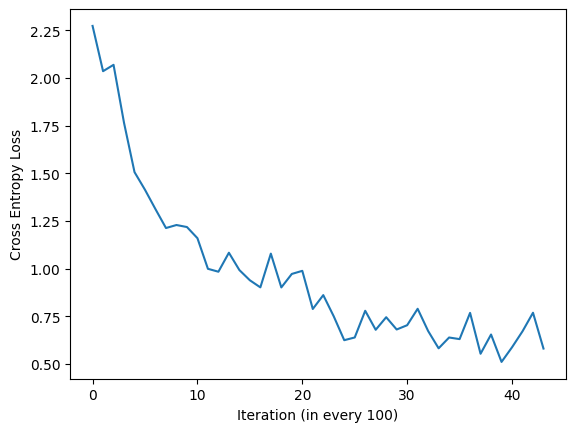

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 100)')
plt.show()

# **Step 4: Save Model With Accuracy**

In [ ]:
os.mkdir('model') #need for first run

In [ ]:
root_path = './model/'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'Bangla_Digits_Handwritten_Recognizer_Logistic_Model_'+str(last_accuracy)+'%_Accuracy.pkl')

os.listdir(root_path)

['Bangla_Digits_Handwritten_Recognizer_Logistic_Model_73%_Accuracy.pkl']

In [ ]:
load_model = True

selected_accuracy = last_accuracy

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Bangla_Digits_Handwritten_Recognizer_Logistic_Model_'+str(selected_accuracy)+'%_Accuracy.pkl'))
    print('Loaded Model With Acuracy = '+str(selected_accuracy)+' %')

Loaded Model With Acuracy = 73 %


# **Step 5 : Test Model**

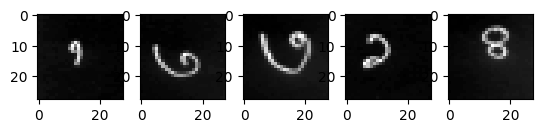

None


In [ ]:
for images, labels in test_loader:
    break

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)
print(plt.show())
plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [7 3 3 1 4]
